## Importation des modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import calendar
import time

## Chargement des frames

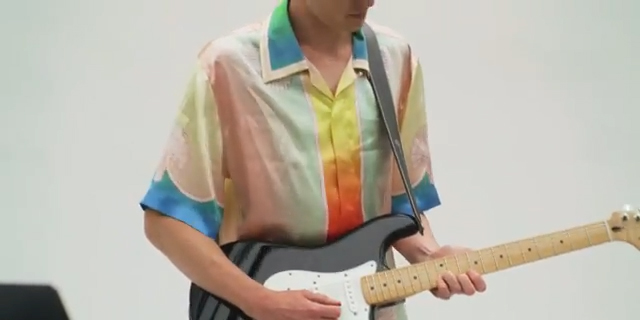

In [2]:
img1 = Image.open("images/LF016.jpg")
img2 = Image.open("images/LF017.jpg")
img1

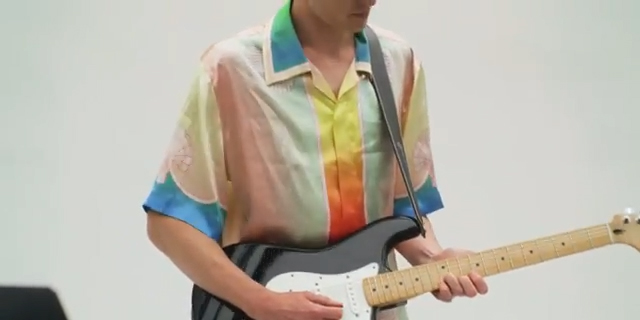

In [3]:
img2

## Création des nd arrays associés aux images

In [4]:
frame_array_1 = np.asarray(img1)
frame_array_2 = np.asarray(img2)
# Vérification 
assert frame_array_1.shape == frame_array_2.shape

# (A) Méthode pixel-wise

## Fonction qui mesure l'écart entre 2 pixels

In [5]:
def get_absolute_diff_sum(pixel_a, pixel_b):
    return (abs((pixel_a).astype(int) - (pixel_b).astype(int))).sum()

## Déterminer les vecteurs de mouvement

### Déterminer le vecteur au niveau d'un pixel

La fonction ci-dessous détermine le pixel de la frame 2 dont l'écart est le plus court avec le pixel x,y de la frame 1:

In [6]:
def get_closer_pixel(frame_array_1,frame_array_2,x,y, step):
    x_left_bound = max(0,x-step)
    x_right_bound = min(frame_array_1.shape[0],x+step+1)
    y_bottom_bound,y_top_bound =max(0,y-step),min(frame_array_1.shape[1],y+step+1)
    best_pixel_coord = None
    best_pixel = None
    pixel_to_find = frame_array_1[x][y]
    for i in range(step,-1,-1):
        for x_neigbour in range(x_left_bound,x_right_bound):
            for y_neigbour in range(y_bottom_bound,y_top_bound):
                if((abs(x_neigbour-x) + abs(y_neigbour-y)) == i):
                    neigbour_pixel = frame_array_2[x_neigbour][y_neigbour]
                    pixel_diff_sum = get_absolute_diff_sum(neigbour_pixel, pixel_to_find)
                    need_to_change = (best_pixel_coord is None)
                    need_to_change = need_to_change or (pixel_diff_sum <= get_absolute_diff_sum(best_pixel, pixel_to_find))
                    if(need_to_change):
                        best_pixel_coord = x_neigbour,y_neigbour
                        best_pixel = neigbour_pixel
        
    return best_pixel_coord
    

Après avoir déterminer le pixel de la frame 2 le plus proche de celui de la frame 1 on renvoie un tuple qui correspond à un vecteur de mouvement.

In [7]:
def get_move_vector(frame_array_1,frame_array_2,x,y,step):
    new_x, new_y = get_closer_pixel(frame_array_1,frame_array_2,x,y,step)
    return new_x-x, new_y-y

### Déterminer les vecteurs de mouvement au niveau de tous les pixels de la frame

Le but va être de générer deux ndarrays u et v. Ces deux arrays correspondent respectivement aux coordonées directionnelles de chaque point de la frame.
u va représenter les abcisses de chaque point et v les ordonnées. 

In [8]:
def generate_move_vectors(frame_array_1,frame_array_2,step):
    count =0
    u = np.ndarray(shape=frame_array_1.shape[0:2])
    u.fill(0.)
    v = np.ndarray(shape=frame_array_1.shape[0:2])
    v.fill(0.)
    total_count = frame_array_1.shape[0]*frame_array_1.shape[1]
    first = time.time()
    for x in range(frame_array_1.shape[0]):
        for y in range(frame_array_1.shape[1]):
            if(count == total_count//100):
                second = time.time()
                estimated_time = (second -first)*100
                print(f'{int(estimated_time)//60} minutes and {int(estimated_time)%60} seconds left ')
            vector= get_move_vector(frame_array_1,frame_array_2,x,y,step)
            u[x][y]= vector[0]
            v[x][y]= vector[1]
            count+=1
    return u,v


## Afficher les vecteurs de mouvement

Il faut maintenant afficher via Quiver l'ensemble des vecteurs de mouvements

In [86]:
STEP = 5
INTERVAL = 10
def compute_movement_vectors(frame_array_1,frame_array_2):
    
    u,v = generate_move_vectors(frame_array_1,frame_array_2,STEP)
    u =  u[::INTERVAL,::INTERVAL]
    v = v[::INTERVAL,::INTERVAL]
    x =  np.arange(frame_array_1.shape[1])  
    y = np.arange(frame_array_1.shape[0]-1,-1,-1) 
    X, Y = np.meshgrid(x[::INTERVAL], y[::INTERVAL])
    return X,Y, u, v
X,Y, u, v = compute_movement_vectors(frame_array_1,frame_array_2)

2 minutes and 13 seconds left 


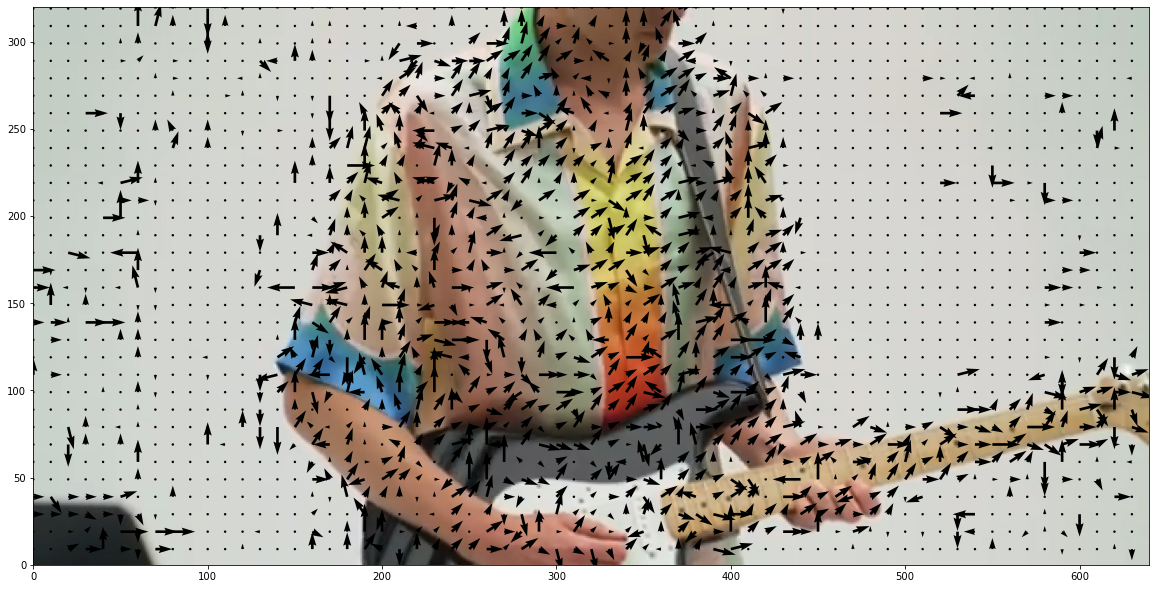

In [87]:
def display_movement_vectors( X,Y, u, v):
    fig, ax = plt.subplots(figsize =(20, 20))
    ax.quiver(X, Y, u, v,scale=200)
    ax.axis([0, frame_array_1.shape[1], 0,frame_array_1.shape[0] ])
    ax.set_aspect('equal')
    plt.imshow(np.flip(frame_array_1,(0)))
    plt.show()

display_movement_vectors(X,Y, u, v)

# (B) Méthode par bloc

In [10]:
def get_block(x,y,frame_array_1,radius):
    left_bound,right_bound = max(0,x-radius),min(x+radius, frame_array_1.shape[0])
    down_bound,up_bound = max(0,y-radius),min(y+radius, frame_array_1.shape[1])
    return frame_array_1[left_bound:right_bound,down_bound:up_bound]

In [13]:
def get_block_diff_sum(block_a, block_b):
    return (abs((block_a).astype(int) - (block_b).astype(int))).sum()

In [46]:
block_a = get_block(160,160,frame_array_1,5)
block_b = get_block(160,160,frame_array_2,5)
get_block_diff_sum(block_a, block_b)

1959

In [33]:
RADIUS = 1
x,y=160,320
block_size = 5
block_a = get_block(x,y,frame_array_1,block_size)
best_coords = max(0,x-current_radius),max(0,y-current_radius)
best_block = get_block(best_coords[0],best_coords[1],frame_array_2,block_size)
best_pixel_diff_sum = None
for current_radius in range(RADIUS,-1,-1):
    left_bound,right_bound = max(0,x-current_radius),min(x+current_radius+1, frame_array_1.shape[0])
    down_bound,up_bound = max(0,y-current_radius),min(y+current_radius+1, frame_array_1.shape[1])
    for curr_x in range(left_bound,right_bound):
        for curr_y in range(down_bound,up_bound):
            if((abs(curr_x-x) + abs(curr_y-y)) != current_radius):
                continue
            block_b = get_block(curr_x,curr_y,frame_array_2,block_size)
            pixel_diff_sum = get_block_diff_sum(block_a, block_b)
            if(best_pixel_diff_sum is None or pixel_diff_sum <= best_pixel_diff_sum):
                best_coords = curr_x,curr_y
                best_block = block_b
                best_pixel_diff_sum = pixel_diff_sum
            #print(f'{ best_coords,pixel_diff_sum,best_pixel_diff_sum = }')


 best_coords,pixel_diff_sum,best_pixel_diff_sum = ((159, 320), 2650, 2650)
 best_coords,pixel_diff_sum,best_pixel_diff_sum = ((159, 320), 3523, 2650)
 best_coords,pixel_diff_sum,best_pixel_diff_sum = ((160, 321), 1723, 1723)
 best_coords,pixel_diff_sum,best_pixel_diff_sum = ((160, 321), 2434, 1723)
 best_coords,pixel_diff_sum,best_pixel_diff_sum = ((160, 321), 2529, 1723)


((160, 321), 1723)

In [50]:
def get_closer_block(x,y,frame_array_1,frame_array_2,block_size, radius):
    block_a = get_block(x,y,frame_array_1,block_size)
    best_coords = max(0,x-radius),max(0,y-radius)
    
    best_block = get_block(best_coords[0],best_coords[1],frame_array_2,block_size)
    print(f"{best_block.shape =}")
    best_pixel_diff_sum = None
    for current_radius in range(radius,-1,-1):
        left_bound,right_bound = max(0,x-current_radius),min(x+current_radius+1, frame_array_1.shape[0])
        down_bound,up_bound = max(0,y-current_radius),min(y+current_radius+1, frame_array_1.shape[1])
        for curr_x in range(left_bound,right_bound):
            for curr_y in range(down_bound,up_bound):
                if((abs(curr_x-x) + abs(curr_y-y)) != current_radius):
                    continue
                block_b = get_block(curr_x,curr_y,frame_array_2,block_size)
                pixel_diff_sum = get_block_diff_sum(block_a, block_b)
                if(best_pixel_diff_sum is None or pixel_diff_sum <= best_pixel_diff_sum):
                    best_coords = curr_x,curr_y
                    best_block = block_b
                    best_pixel_diff_sum = pixel_diff_sum
    return best_coords


In [51]:
def get_move_vector_by_block_wise(x,y,frame_array_1,frame_array_2,block_size, radius):
    new_x,new_y = get_closer_block(x,y,frame_array_1,frame_array_2,block_size, radius)
    return new_x-x,new_y-y